<center>
<h1>Reinforcement Learning</h1>
<h1 style="color:blue">Defining & Solving RL Environments</h1>
</center>

## Part 1 [Total: 30 points] - Defining RL Environments

### 1.1 Deterministic Environment [15 points]

Steps:

1. Define a deterministic environment, where P(s′, r|s, a) = {0, 1}.
2. Run a random agent for at least 10 timesteps to show that the environment logic is defined correctly. Print the current state, chosen action, reward and return your grid world visualization for each step.
Environment requirements:

- Min number of states: 12
- Min number of actions: 4
- Min number of rewards: 4

Environment definition should follow the Gymnasium structure, which includes the basic methods:

```
def __init__:
# Initializes the class
# Define action and observation space
def step:
# Executes one timestep within the environment
# Input to the function is an action
def reset:
# Resets the state of the environment to an initial state
1
def render:
# Visualizes the environment
# Any form like vector representation or visualizing using matplotlib will be sufficient
```

Import Statements

In [1]:
import gym as gym
from gym import spaces
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import pickle

#### Frozen Lake Environment

Description: The agent is on a frozen lake and must navigate to the goal while avoiding holes and collecting Gems.

In [2]:
class FrozenLakeEnv(gym.Env):
    metadata = {'render.modes': []}
    def __init__(self, gamma=0.9, alpha=0.1, max_timestamp=10):
        self.gamma = gamma
        self.alpha = alpha

        self.obs_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timestamp = max_timestamp
        self.timestep = 0

        ## STATES SET #############
        self.state = np.zeros((4, 4))
        self.myskater = np.asarray([0, 0])
        self.goal_loc = np.asarray([3, 3])
        self.gem_loc = [np.asarray([0, 2]), np.asarray([3, 2])]
        self.hole_loc = [np.asarray([1, 3]), np.asarray([2, 0])]

        self.state[tuple(self.myskater)] = 0.2
        self.state[tuple(self.goal_loc)] = 0.8
        for pos in self.gem_loc:
            self.state[tuple(pos)] = 0.5
        for pos in self.hole_loc:
            self.state[tuple(pos)] = 0.4
        ##########################
        
        self.prev_state = np.zeros((4, 4))
        self.prev_action = None
        self.penalty_counter = 0  
        self.flag_out_grid = 0  


    def step(self, action):
        self.prev_state = np.copy(self.state)  
        self.prev_action = action  
        self.flag_out_grid = 0  

        ## ACTIONS SET #############
        if action == 0:    # moves right
            self.myskater[0] += 1
        elif action == 1:   # moves left
            self.myskater[0] -= 1
        elif action == 2:   # moves up
            self.myskater[1] += 1 
        elif action == 3:    # moves down
            self.myskater[1] -= 1
        ##########################
            
        self.myskater = np.clip(self.myskater, 0, 3)

        # If the agent is in the same position as the previous step, choose a different action
        prev_state_positions = np.argwhere(self.prev_state == 0.2)
        if len(prev_state_positions) > 0 and np.array_equal(self.myskater, prev_state_positions[0]):
            while action == self.prev_action:
                action = self.action_space.sample()
            self.flag_out_grid = 1

        self.state = np.zeros((4, 4))
        self.state[tuple(self.myskater)] = 0.2
        self.state[tuple(self.goal_loc)] = 0.8
        for pos in self.gem_loc:
            self.state[tuple(pos)] = 0.5
        for pos in self.hole_loc:
            self.state[tuple(pos)] = 0.4

        obs = self.state.flatten()
        reward = self.calculate_reward()
        penalty = any(np.array_equal(self.myskater, pos) for pos in self.hole_loc)
        if penalty:
            self.penalty_counter += 1 
        self.timestep += 1

        terminated = True if np.array_equal(self.myskater, self.goal_loc) else self.timestep >= self.max_timestamp
        truncated = True if np.any((self.myskater < 0) | (self.myskater > 3)) else False
        if truncated:
            self.flag_out_grid = 1  

        info = {}

        return self.state.flatten(), reward, terminated, truncated, info

    def reset(self, **kwargs):
        self.state = np.zeros((4, 4))
        self.myskater = np.asarray([0, 0])
        self.state[tuple(self.myskater)] = 0.2
        self.state[tuple(self.goal_loc)] = 0.8

        for pos in self.gem_loc:
            self.state[tuple(pos)] = 0.5
        for pos in self.hole_loc:
            self.state[tuple(pos)] = 0.4

        self.prev_state = np.zeros((4, 4))
        self.prev_action = None
        self.flag_out_grid = 0 
        
        obs = self.state.flatten()
        self.timestep = 0
        info = {}
        self.penalty_counter = 0
        return obs, info

    def calculate_reward(self):
        prev_myskateritions = np.argwhere(self.prev_state == 0.2)
        if prev_myskateritions.size == 0:
            prev_myskaterition = self.myskater
        else:
            prev_myskaterition = prev_myskateritions[0]

        # Calculating distance to goal before and after the step
        prev_distance_to_goal = np.linalg.norm(self.goal_loc - prev_myskaterition)
        current_distance_to_goal = np.linalg.norm(self.goal_loc - self.myskater)


        ## REWARDS SET #############
        if np.array_equal(self.myskater, self.goal_loc):
            reward = 10  # Positive reward for reaching goal
        elif np.array_equal(self.myskater, self.hole_loc[0]):
            reward = -5  # negative reward for reaching holes 1
        elif np.array_equal(self.myskater, self.hole_loc[1]):
            reward = -6   # negative reward for reaching holes 2
        elif np.array_equal(self.myskater, self.gem_loc[0]):
            reward = 5   # positive reward for reaching gems 1
        elif np.array_equal(self.myskater, self.gem_loc[1]):
            reward = 6  # positive reward for reaching gems 2
        elif current_distance_to_goal < prev_distance_to_goal:
            reward = 1  # Positive reward for moving closer to goal
        elif current_distance_to_goal > prev_distance_to_goal:
            reward = -1  # Negative reward for moving away to goal
        else:
            reward = -0.1  # Slight negative reward for no change
        ##########################
        
        return reward
    
    def get_penalty_count(self):
        return self.penalty_counter

    def render(self):
        fig, ax = plt.subplots()
        plt.title('Frozen Lake Environment')

        # Load and display the background image
        background_img = plt.imread('images/frozen_lake.jpg')
        ax.imshow(background_img, extent=(-0.5, 3.5, -0.5, 3.5), origin='upper')

       
        skater_img = plt.imread('images/icons8-skateboard-100.png')
        hole_img = plt.imread('images/icons8-hole-100.png')
        gem_img = plt.imread('images/icons8-gems-100.png')
        goal_img = plt.imread('images/icons8-flag-100.png')
        skater_hole_drown_img = plt.imread('images/agent_hole_drown.png')
        skater_gem_lottery_img = plt.imread('images/agent_gems_lottery.png')
        agent_flag_winner_img = plt.imread('images/agent_flag_winner.png')
        agent_grid_cross_img = plt.imread('images/agent_grid_cross.png')

        # Plot Skater
        myskater = self.myskater
        if self.flag_out_grid:
            skater_img = agent_grid_cross_img
        agent_box = AnnotationBbox(OffsetImage(skater_img, zoom=0.4), myskater, frameon=False)
        ax.add_artist(agent_box)

        # Plot Holes
        for hole_loc in self.hole_loc:
            hole_loc = hole_loc
            if np.array_equal(self.myskater, hole_loc):
                hole_img = skater_hole_drown_img
            else:
                hole_img = plt.imread('images/icons8-hole-100.png')
            rock_box = AnnotationBbox(OffsetImage(hole_img, zoom=0.4), hole_loc, frameon=False)
            ax.add_artist(rock_box)

        # Plot Gems
        for gem_loc in self.gem_loc:
            gem_loc = gem_loc
            if np.array_equal(self.myskater, gem_loc):
                gem_img = skater_gem_lottery_img
            else:
                gem_img = plt.imread('images/icons8-gems-100.png')
            battery_box = AnnotationBbox(OffsetImage(gem_img, zoom=0.4), gem_loc, frameon=False)
            ax.add_artist(battery_box)

        # Plot goal
        goal_loc = self.goal_loc
        goal_loc = self.goal_loc
        if np.array_equal(self.myskater, goal_loc):
            goal_img = agent_flag_winner_img
        else:
            goal_img = plt.imread('images/icons8-flag-100.png')
        goal_box = AnnotationBbox(OffsetImage(goal_img, zoom=0.4), goal_loc, frameon=False)
        ax.add_artist(goal_box)

        plt.xticks(np.arange(-0.5, 4.5, 1))
        plt.yticks(np.arange(-0.5, 4.5, 1))
        plt.gca().set_xticklabels(np.arange(-0.5, 4.5, 1))
        plt.gca().set_yticklabels(np.arange(-0.5, 4.5, 1))
        plt.show()

    def obs_space_to_index(self, obs):
        myskater = np.argwhere(obs.reshape(4, 4) == 0.2)
        if myskater.size == 0:
            return 0 
        return myskater[0, 0] * 4 + myskater[0, 1]



Run a random agent for at least 10 timesteps to show that the environment logic is defined correctly. Print the current state, chosen action, reward and return your grid world visualization for each step.

Step 1 - Action: 3, Reward: -0.1
Current State:
[[0.2 0.  0.5 0. ]
 [0.  0.  0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


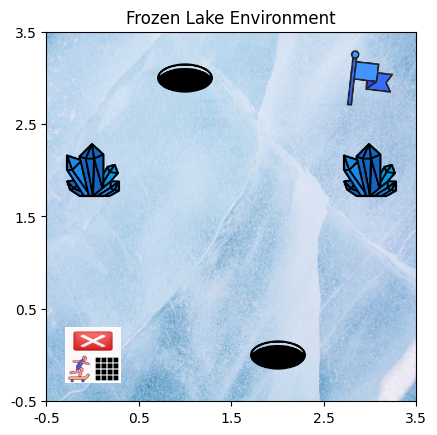

Step 2 - Action: 0, Reward: 1
Current State:
[[0.  0.  0.5 0. ]
 [0.2 0.  0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


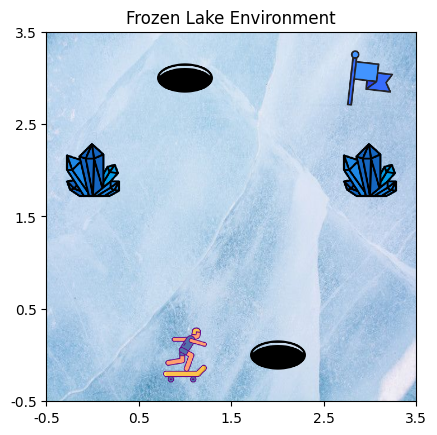

Step 3 - Action: 1, Reward: -1
Current State:
[[0.2 0.  0.5 0. ]
 [0.  0.  0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


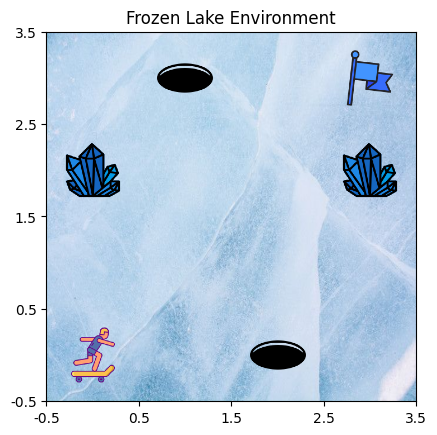

Step 4 - Action: 1, Reward: -0.1
Current State:
[[0.2 0.  0.5 0. ]
 [0.  0.  0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


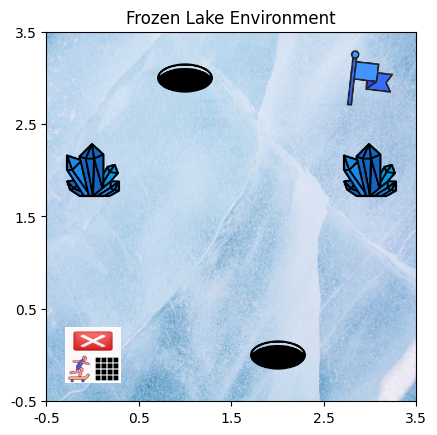

Step 5 - Action: 3, Reward: -0.1
Current State:
[[0.2 0.  0.5 0. ]
 [0.  0.  0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


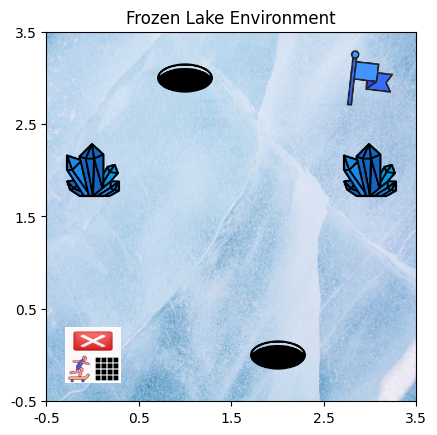

Step 6 - Action: 2, Reward: 1
Current State:
[[0.  0.2 0.5 0. ]
 [0.  0.  0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


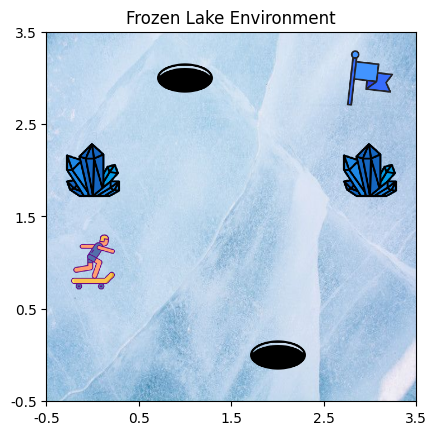

Step 7 - Action: 0, Reward: 1
Current State:
[[0.  0.  0.5 0. ]
 [0.  0.2 0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


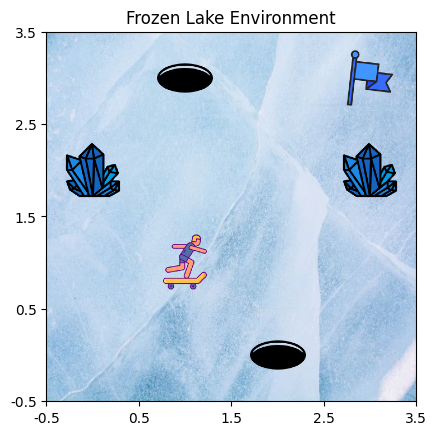

Step 8 - Action: 0, Reward: 1
Current State:
[[0.  0.  0.5 0. ]
 [0.  0.  0.  0.4]
 [0.4 0.2 0.  0. ]
 [0.  0.  0.5 0.8]]


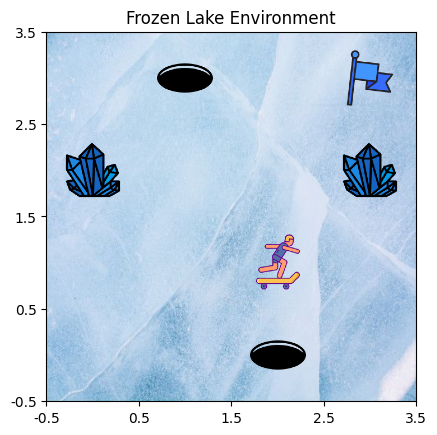

Step 9 - Action: 1, Reward: -1
Current State:
[[0.  0.  0.5 0. ]
 [0.  0.2 0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


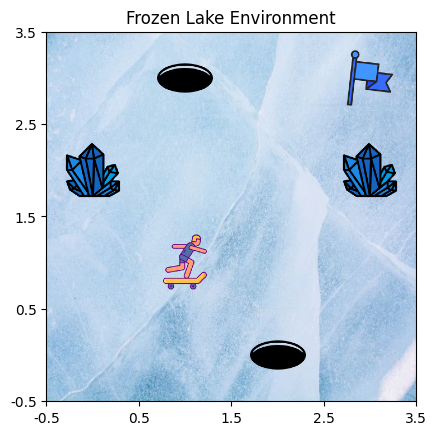

Step 10 - Action: 1, Reward: -1
Current State:
[[0.  0.2 0.5 0. ]
 [0.  0.  0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


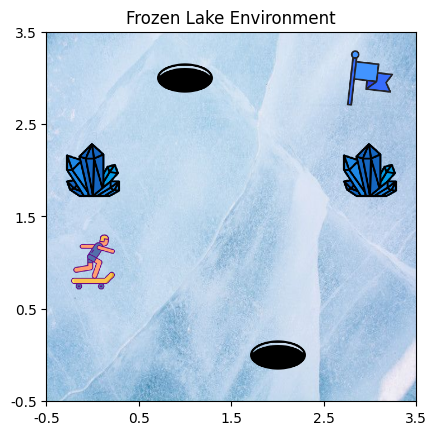

In [3]:
env_det = FrozenLakeEnv()
for _ in range(10):
    action = env_det.action_space.sample()
    obs, reward, terminated, truncated, info = env_det.step(action)
    print(f"Step {_ + 1} - Action: {action}, Reward: {reward}")
    print("Current State:")
    print(env_det.state)
    env_det.render()

    if terminated or truncated:
        env_det.state = np.copy(env_det.prev_state) 
        env_det.myagent = np.argwhere(env_det.state == 0.2)[0]

### 1.2 Stochastic Environment [15 points]

Steps:
1. Define a stochastic environment, where Summation given s′,r (P(s′, r|s, a)) = 1. A modified version of the environment
defined in Part 1.1 should be used.

2. Run a random agent for at least 10 timesteps to show that the environment logic is defined correctly.
Print the current state, chosen action, reward and return your grid world visualization for each step.

In [4]:
class StochasticFrozenLakeEnv(gym.Env):
    metadata = {'render.modes': []}

    def __init__(self, gamma=0.9, alpha=0.1, max_timestamp=10):
        self.gamma = gamma
        self.alpha = alpha
        
        self.obs_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timestamp = max_timestamp
        self.timestep = 0

        self.state = np.zeros((4, 4))
        self.myskater = np.asarray([0, 0])
        self.goal_loc = np.asarray([3, 3])
        self.gem_loc = [np.asarray([0, 2]), np.asarray([3, 2])]
        self.hole_loc = [np.asarray([1, 3]), np.asarray([2, 0])]

        self.state[tuple(self.myskater)] = 0.2
        self.state[tuple(self.goal_loc)] = 0.8
        for pos in self.gem_loc:
            self.state[tuple(pos)] = 0.5
        for pos in self.hole_loc:
            self.state[tuple(pos)] = 0.4

        self.prev_state = np.zeros((4, 4))
        self.prev_action = None
        self.penalty_counter = 0
        self.flag_out_grid = 0

    def step(self, action):
        self.prev_state = np.copy(self.state)
        self.prev_action = action
        self.flag_out_grid = 0

        randomness = [0.35, 0.15, 0.35, 0.15]  # probability for each action
        action = np.random.choice(4,p=randomness)

        if action == 0:
            self.myskater[0] += 1
        elif action == 1:
            self.myskater[0] -= 1
        elif action == 2:
            self.myskater[1] += 1
        elif action == 3:
            self.myskater[1] -= 1

        self.myskater = np.clip(self.myskater, 0, 3)

        prev_state_positions = np.argwhere(self.prev_state == 0.2)
        if len(prev_state_positions) > 0:
            if np.array_equal(self.myskater, prev_state_positions[0]):
                while action == self.prev_action:
                    action = np.random.choice(4, p=randomness)
                self.flag_out_grid = 1

        self.state = np.zeros((4, 4))
        self.state[tuple(self.myskater)] = 0.2
        self.state[tuple(self.goal_loc)] = 0.8
        for pos in self.gem_loc:
            self.state[tuple(pos)] = 0.5
        for pos in self.hole_loc:
            self.state[tuple(pos)] = 0.4

        obs = self.state.flatten()
        reward = self.calculate_reward()
        penalty = any(np.array_equal(self.myskater, pos) for pos in self.hole_loc)
        if penalty:
            self.penalty_counter += 1
        self.timestep += 1

        terminated = True if np.array_equal(self.myskater, self.goal_loc) else self.timestep >= self.max_timestamp
        truncated = True if np.any((self.myskater < 0) | (self.myskater > 3)) else False
        if terminated or truncated:
            self.flag_out_grid=1
            self.state = np.copy(self.prev_state) 

            # Check if there are any positions with a value of 0.2
            positions_with_value_0_2 = np.argwhere(self.state == 0.2)

            if len(positions_with_value_0_2) > 0:
                # Ensure that the index is within bounds
                index = np.random.randint(len(positions_with_value_0_2))
                self.myagent = positions_with_value_0_2[index]
                
        info = {}

        return self.state.flatten(), reward, terminated, truncated, info
        
    def reset(self, **kwargs):
        self.state = np.zeros((4, 4))
        self.myskater = np.asarray([0, 0])
        self.state[tuple(self.myskater)] = 0.2
        self.state[tuple(self.goal_loc)] = 0.8

        for pos in self.gem_loc:
            self.state[tuple(pos)] = 0.5
        for pos in self.hole_loc:
            self.state[tuple(pos)] = 0.4

        self.prev_state = np.zeros((4, 4))
        self.prev_action = None
        self.flag_out_grid = 0 
        
        obs = self.state.flatten()
        self.timestep = 0
        info = {}
        self.penalty_counter = 0
        return obs, info

    def calculate_reward(self):
        prev_myskateritions = np.argwhere(self.prev_state == 0.2)
        if prev_myskateritions.size == 0:
            prev_myskaterition = self.myskater
        else:
            prev_myskaterition = prev_myskateritions[0]

        # Calculating distance to goal before and after the step
        prev_distance_to_goal = np.linalg.norm(self.goal_loc - prev_myskaterition)
        current_distance_to_goal = np.linalg.norm(self.goal_loc - self.myskater)


        ## REWARDS SET #############
        if np.array_equal(self.myskater, self.goal_loc):
            reward = 10  # Positive reward for reaching goal
        elif np.array_equal(self.myskater, self.hole_loc[0]):
            reward = -5  # negative reward for reaching holes 1
        elif np.array_equal(self.myskater, self.hole_loc[1]):
            reward = -6   # negative reward for reaching holes 2
        elif np.array_equal(self.myskater, self.gem_loc[0]):
            reward = 5   # positive reward for reaching gems 1
        elif np.array_equal(self.myskater, self.gem_loc[1]):
            reward = 6  # positive reward for reaching gems 2
        elif current_distance_to_goal < prev_distance_to_goal:
            reward = 1  # Positive reward for moving closer to goal
        elif current_distance_to_goal > prev_distance_to_goal:
            reward = -1  # Negative reward for moving away to goal
        else:
            reward = -0.1  # Slight negative reward for no change
        ##########################
        
        return reward
    
    def get_penalty_count(self):
        return self.penalty_counter

    def render(self):
        fig, ax = plt.subplots()
        plt.title('Frozen Lake Environment')

        # Load and display the background image
        background_img = plt.imread('images/frozen_lake.jpg')
        ax.imshow(background_img, extent=(-0.5, 3.5, -0.5, 3.5), origin='upper')

       
        skater_img = plt.imread('images/icons8-skateboard-100.png')
        hole_img = plt.imread('images/icons8-hole-100.png')
        gem_img = plt.imread('images/icons8-gems-100.png')
        goal_img = plt.imread('images/icons8-flag-100.png')
        skater_hole_drown_img = plt.imread('images/agent_hole_drown.png')
        skater_gem_lottery_img = plt.imread('images/agent_gems_lottery.png')
        agent_flag_winner_img = plt.imread('images/agent_flag_winner.png')
        agent_grid_cross_img = plt.imread('images/agent_grid_cross.png')

        # Plot Skater
        myskater = self.myskater
        if self.flag_out_grid:
            skater_img = agent_grid_cross_img
        agent_box = AnnotationBbox(OffsetImage(skater_img, zoom=0.4), myskater, frameon=False)
        ax.add_artist(agent_box)

        # Plot Holes
        for hole_loc in self.hole_loc:
            hole_loc = hole_loc
            if np.array_equal(self.myskater, hole_loc):
                hole_img = skater_hole_drown_img
            else:
                hole_img = plt.imread('images/icons8-hole-100.png')
            rock_box = AnnotationBbox(OffsetImage(hole_img, zoom=0.4), hole_loc, frameon=False)
            ax.add_artist(rock_box)

        # Plot Gems
        for gem_loc in self.gem_loc:
            gem_loc = gem_loc
            if np.array_equal(self.myskater, gem_loc):
                gem_img = skater_gem_lottery_img
            else:
                gem_img = plt.imread('images/icons8-gems-100.png')
            battery_box = AnnotationBbox(OffsetImage(gem_img, zoom=0.4), gem_loc, frameon=False)
            ax.add_artist(battery_box)

        # Plot goal
        goal_loc = self.goal_loc
        goal_loc = self.goal_loc
        if np.array_equal(self.myskater, goal_loc):
            goal_img = agent_flag_winner_img
        else:
            goal_img = plt.imread('images/icons8-flag-100.png')
        goal_box = AnnotationBbox(OffsetImage(goal_img, zoom=0.4), goal_loc, frameon=False)
        ax.add_artist(goal_box)

        plt.xticks(np.arange(-0.5, 4.5, 1))
        plt.yticks(np.arange(-0.5, 4.5, 1))
        plt.gca().set_xticklabels(np.arange(-0.5, 4.5, 1))
        plt.gca().set_yticklabels(np.arange(-0.5, 4.5, 1))
        plt.show()

    def obs_space_to_index(self, obs):
        myskater = np.argwhere(obs.reshape(4, 4) == 0.2)
        if myskater.size == 0:
            return 0 
        return myskater[0, 0] * 4 + myskater[0, 1]


Step 1 - Action: 3, Reward: 1
Current State:
[[0.  0.2 0.5 0. ]
 [0.  0.  0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


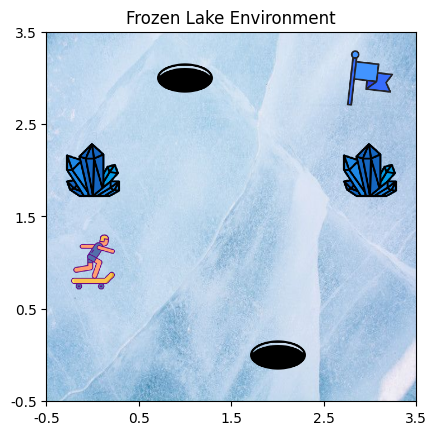

Step 2 - Action: 3, Reward: -1
Current State:
[[0.2 0.  0.5 0. ]
 [0.  0.  0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


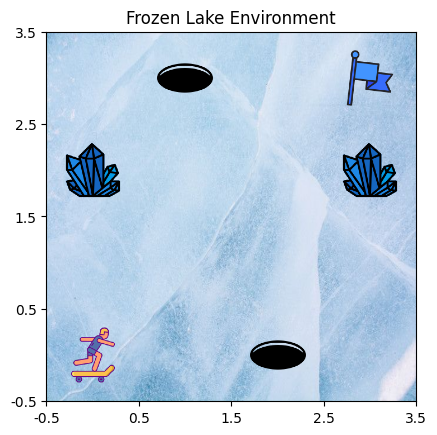

Step 3 - Action: 0, Reward: 1
Current State:
[[0.  0.2 0.5 0. ]
 [0.  0.  0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


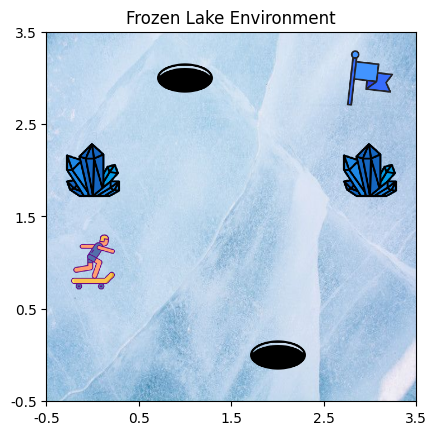

Step 4 - Action: 0, Reward: -0.1
Current State:
[[0.  0.2 0.5 0. ]
 [0.  0.  0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


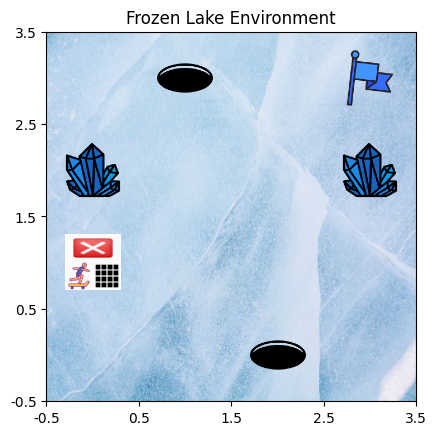

Step 5 - Action: 2, Reward: 1
Current State:
[[0.  0.  0.5 0. ]
 [0.  0.2 0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


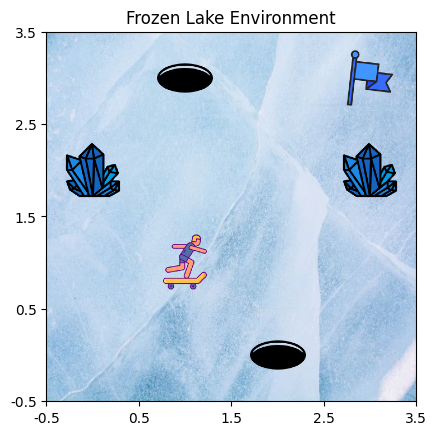

Step 6 - Action: 2, Reward: 1
Current State:
[[0.  0.  0.5 0. ]
 [0.  0.  0.  0.4]
 [0.4 0.2 0.  0. ]
 [0.  0.  0.5 0.8]]


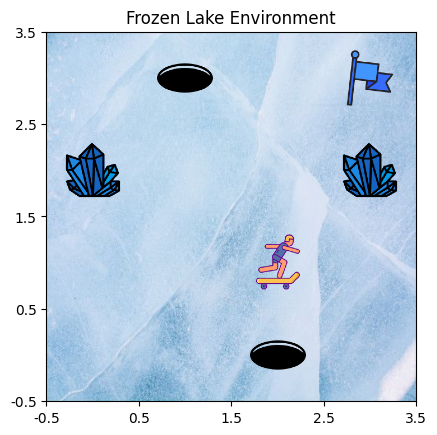

Step 7 - Action: 2, Reward: 1
Current State:
[[0.  0.  0.5 0. ]
 [0.  0.  0.  0.4]
 [0.4 0.  0.2 0. ]
 [0.  0.  0.5 0.8]]


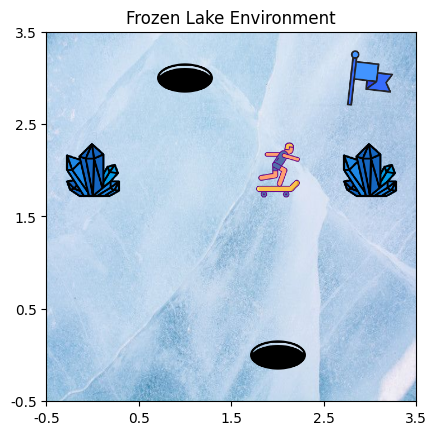

Step 8 - Action: 1, Reward: 6
Current State:
[[0.  0.  0.5 0. ]
 [0.  0.  0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.  0.5 0.8]]


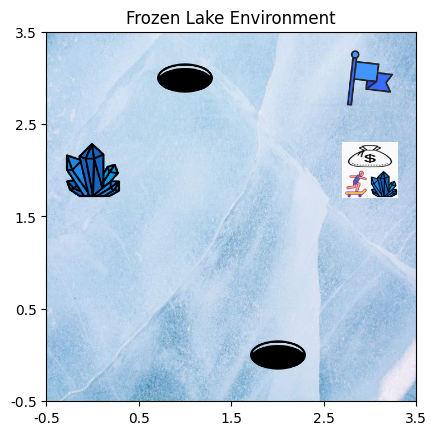

Step 9 - Action: 0, Reward: -0.1
Current State:
[[0.  0.  0.5 0. ]
 [0.  0.  0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.2 0.5 0.8]]


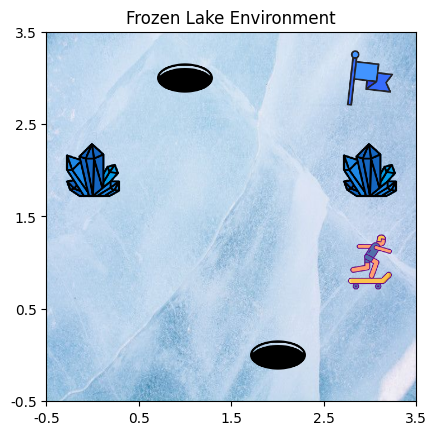

Step 10 - Action: 0, Reward: -1
Current State:
[[0.  0.  0.5 0. ]
 [0.  0.  0.  0.4]
 [0.4 0.  0.  0. ]
 [0.  0.2 0.5 0.8]]


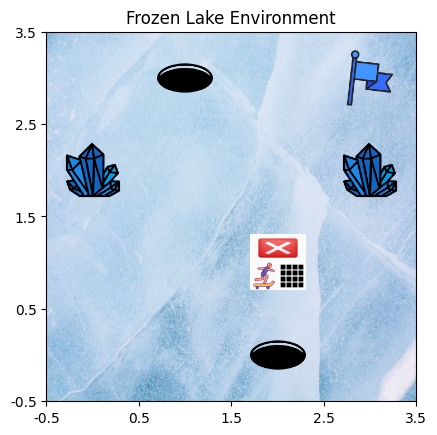

In [5]:
env_stoc = StochasticFrozenLakeEnv()
for _ in range(10):
    action = env_stoc.action_space.sample()
    obs, reward, terminated, truncated, info = env_stoc.step(action)
    print(f"Step {_ + 1} - Action: {action}, Reward: {reward}")
    print("Current State:")
    print(env_stoc.state)
    env_stoc.render()

    if terminated or truncated:
        env_stoc.state = np.copy(env_stoc.prev_state) 

        positions_with_value_0_2 = np.argwhere(env_stoc.state == 0.2)

        if len(positions_with_value_0_2) > 0:
            index = np.random.randint(len(positions_with_value_0_2))
            env_stoc.myagent = positions_with_value_0_2[index]
        else:
            env_stoc.myagent = (0, 0)
